In [ ]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import os, sys
from PIL import Image

import pandas as pd

import torch
from torch.utils.data import DataLoader
from preprocessing import *
from experimental_neural_nets import Road_data, UNet
from road_correction import process_roads, f1_loss_numpy

c:\Users\hudrya\anaconda3\lib\site-packages\paramiko\pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
c:\Users\hudrya\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from this module in 45.0.0.
  "class": algorithms.Blowfish,
c:\Users\hudrya\anaconda3\lib\site-packages\paramiko\transport.py:243: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,


In [2]:
# Global params for UNet and Road Correction (SEARCH or LOAD, option to SAVE if SEARCH)
UNET_SEARCH = True
SAVE_UNET = True
ROAD_CORRECTION_SEARCH = True
SAVE_RC_PARAMS = True
UNET_MODEL_LOAD = 'UNet_model.pth'
UNET_MODEL_SAVE = 'UNet_model.pth'
RC_LOAD = 'RC_params.pth'
RC_SAVE = 'RC_params.pth'

In [3]:
def load_image(infilename):
    data = mpimg.imread(infilename)
    return data

In [ ]:
root_dir = "data/training/"

image_dir = root_dir + "images/"
files = os.listdir(image_dir)
n = min(100, len(files))  # Load maximum 100 images
print("Loading " + str(n) + " images")
imgs = [load_image(image_dir + files[i]) for i in range(n)]
print(files[0])

gt_dir = root_dir + "groundtruth/"
print("Loading " + str(n) + " images")
gt_imgs = [load_image(gt_dir + files[i]) for i in range(n)]
print(files[0])

#imgs,gt_imgs = rotate_train_data(imgs,gt_imgs)
#imgs,gt_imgs = flip_train_data(imgs,gt_imgs)

Loading 10 images
satImage_001.png
Loading 10 images
satImage_001.png


In [ ]:
# Search for best parameters of the model (base_C and num_layers) or load from save
if UNET_SEARCH:

    # Modulate search
    num_epochs = 10
    batch_size = 10
    bases = [4,8,16,32]
    layers = np.arange(3,7)

    dataset = Road_data(imgs,gt_imgs)

    best_loss = np.inf
    best_base = 0
    best_n_layer = 0


    for base_c in bases:
        for n_layer in layers:

            model = UNet(base_c=base_c,num_layers=n_layer)
            losses = []
            criterion = torch.nn.BCEWithLogitsLoss()
            optimizer = torch.optim.Adam(model.parameters(), lr=0.002)
            scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
            dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

            for epoch in range(num_epochs):
                for batch_idx, (data, target) in enumerate(dataloader):

                    optimizer.zero_grad()
                    output = model(data)
                    loss = criterion(output, target)
                    loss.backward()
                    optimizer.step()

                losses.append(loss)
                scheduler.step()
                print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item():.4f}")
                
            c_loss = min(losses)
            if c_loss < best_loss:
                best_base = base_c
                best_n_layer = n_layer
                best_loss = c_loss

down
(8, 16)
(16, 32)
Up
(32, 16)
(16, 8)
Epoch 1/10, Loss: 0.8620
Epoch 2/10, Loss: 0.8535
Epoch 3/10, Loss: 0.8440
Epoch 4/10, Loss: 0.8351
Epoch 5/10, Loss: 0.8258
Epoch 6/10, Loss: 0.8185
Epoch 7/10, Loss: 0.8143
Epoch 8/10, Loss: 0.8101
Epoch 9/10, Loss: 0.8062
Epoch 10/10, Loss: 0.8032


In [6]:
# training of best model or loading from save
if UNET_SEARCH:

    # Modulate training
    num_epochs = 20
    batch_size = 10

    dataset = Road_data(imgs,gt_imgs)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    model = UNet(base_c=best_base,num_layers=best_n_layer)
    criterion = torch.nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.002)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    for epoch in range(num_epochs):
        for batch_idx, (data, target) in enumerate(dataloader):

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

        scheduler.step()
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item():.4f}")
    
    # optional save
    if SAVE_UNET:
        torch.save(model, UNET_MODEL_SAVE)
        
else:
    model = torch.load(UNET_MODEL_LOAD)

down
(8, 16)
(16, 32)
Up
(32, 16)
(16, 8)
Epoch 1/20, Loss: 0.8823
Epoch 2/20, Loss: 0.8776
Epoch 3/20, Loss: 0.8725
Epoch 4/20, Loss: 0.8685
Epoch 5/20, Loss: 0.8645
Epoch 6/20, Loss: 0.8605
Epoch 7/20, Loss: 0.8567
Epoch 8/20, Loss: 0.8527
Epoch 9/20, Loss: 0.8497
Epoch 10/20, Loss: 0.8468
Epoch 11/20, Loss: 0.8442
Epoch 12/20, Loss: 0.8440
Epoch 13/20, Loss: 0.8437
Epoch 14/20, Loss: 0.8433
Epoch 15/20, Loss: 0.8430
Epoch 16/20, Loss: 0.8427
Epoch 17/20, Loss: 0.8424
Epoch 18/20, Loss: 0.8421
Epoch 19/20, Loss: 0.8418
Epoch 20/20, Loss: 0.8414


In [ ]:
# search of best params for road correction after model prediction or load them from 

if ROAD_CORRECTION_SEARCH:

    # Modulate search
    outlier_sizes = np.arange(10, 100, 10)
    shape_sizes = np.arange(3, 10)

    dataset = Road_data(imgs, gt_imgs)
    dataloader = DataLoader(dataset, batch_size=20, shuffle=True)

    threshold = 0.5
    best_outlier_size = 0
    best_shape_size = 0
    best_loss = np.inf

    for outlier_size in outlier_sizes:
        for shape_size in shape_sizes:

            print(f'outlier size : {outlier_size} | shape size : {shape_size}')
            c_losses = []
            
            for batch_idx, (data, target) in enumerate(dataloader):

                gt = target
                images = data
                pred = model(data)

                gt_np = gt.detach().cpu().numpy()
                pred_np = pred.detach().cpu().numpy()
                test_pred = np.array([
                    process_roads(raw_map=raw_map, threshold=threshold, outlier_size=outlier_size, shape_size=shape_size) 
                    for raw_map in pred_np
                    ])
                
                c_losses.append(np.mean([f1_loss_numpy(p, truth) for p, truth in zip(test_pred,gt_np)]))
            
            c_loss = np.mean(c_losses)
            if c_loss < best_loss:
                best_loss = c_loss
                best_outlier_size = outlier_size
                best_shape_size = shape_size

    # optional save
    if SAVE_RC_PARAMS:
        best_params = {'best_outlier_size':best_outlier_size,'best_shape_size':best_shape_size}
        torch.save(best_params, RC_SAVE)

else:
    best_params = torch.load(RC_LOAD)
    best_outlier_size = best_params['best_outlier_size']
    best_shape_size = best_params['best_shape_size']


outlier size : 10 | shape size : 3
outlier size : 11 | shape size : 3


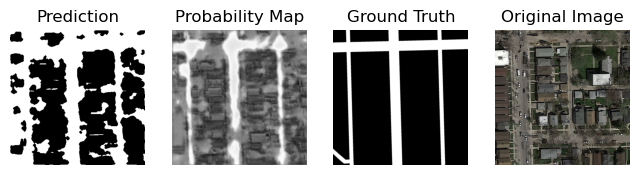

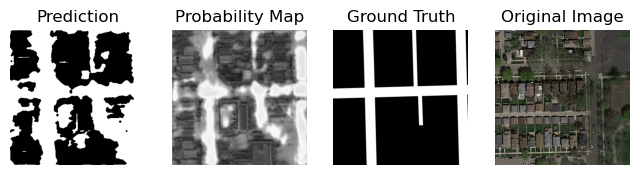

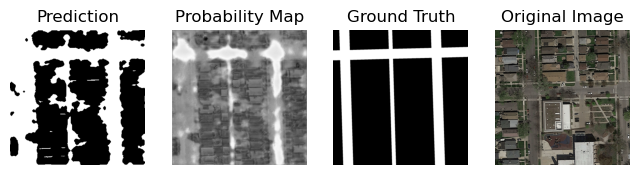

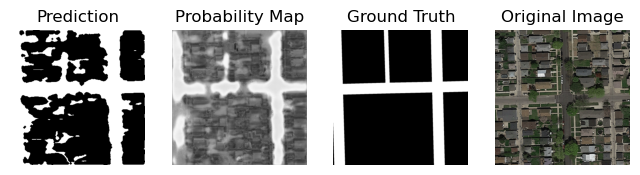

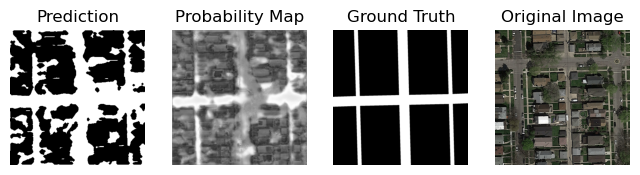

In [16]:
# get plot examples with the trained or loaded UNet model, and train or loaded RC parameters (still on train data)
n_examples = 5

dataset_check = Road_data(imgs, gt_imgs)
dataloader = DataLoader(dataset_check, batch_size=n_examples, shuffle=True)

for batch_idx, (data, target) in enumerate(dataloader):

    gt = target
    pred = model(data)
    gt_np = gt.detach().cpu().numpy()
    pred_np = pred.detach().cpu().numpy()

    for i in range(n_examples):
        fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(8, 8))

        prediction, _, _, _ = process_roads(raw_map=pred_np[i], threshold=threshold, outlier_size=best_outlier_size, shape_size=best_shape_size)
        axes[0].imshow(prediction, cmap='gray')
        axes[0].set_title("Prediction")
        
        axes[1].imshow(pred_np[i], cmap='gray')
        axes[1].set_title("Probability Map")

        axes[2].imshow(gt_np[i], cmap='gray')
        axes[2].set_title("Ground Truth")

        img_np = images[i].permute(1, 2, 0).cpu().numpy() 

        axes[3].imshow(img_np)
        axes[3].set_title("Original Image")

        axes[0].axis("off")
        axes[1].axis("off")
        axes[2].axis("off")
        axes[3].axis("off")

        plt.show()
    
    break

In [ ]:
# best_shape_size = 8
# best_outlier_size = 80
# best_threshold = 0.45 - 0.50
# Copy of output
'''
(2,2)
Epoch 10/10, Loss: 0.7271
(3,2)
Epoch 10/10, Loss: 0.7983
(4,2)
Epoch 6/10, Loss: 0.8487
Epoch 7/10, Loss: 0.8037
Epoch 8/10, Loss: 0.7896
Epoch 9/10, Loss: 0.8194
Epoch 10/10, Loss: 0.8030
(5,2)
Epoch 10/10, Loss: 0.7603
(6,2)
Epoch 7/10, Loss: 0.8367
Epoch 8/10, Loss: 0.8041
Epoch 9/10, Loss: 0.7919
Epoch 10/10, Loss: 0.8159
(2,4)
Epoch 10/10, Loss: 0.7353
(3,4)
Epoch 10/10, Loss: 0.7317
(4,4)
Epoch 7/10, Loss: 0.7212
Epoch 8/10, Loss: 0.7214
Epoch 9/10, Loss: 0.7083
Epoch 10/10, Loss: 0.7170
(5,4)
Epoch 7/10, Loss: 0.7716
Epoch 8/10, Loss: 0.7631
Epoch 9/10, Loss: 0.7285
Epoch 10/10, Loss: 0.7535
(6,4)
Epoch 7/10, Loss: 0.7280
Epoch 8/10, Loss: 0.7524
Epoch 9/10, Loss: 0.7306
Epoch 10/10, Loss: 0.6984
(2,8)
Epoch 10/10, Loss: 0.6975
(3,8)
Epoch 10/10, Loss: 0.7063
(4,8)
Epoch 10/10, Loss: 0.6899
(5,8)
Epoch 7/10, Loss: 0.7355
Epoch 8/10, Loss: 0.7171
Epoch 9/10, Loss: 0.6915
Epoch 10/10, Loss: 0.7085
(6,8)
Epoch 10/10, Loss: 0.6920
down
(2,16)
Epoch 8/10, Loss: 0.6867
Epoch 9/10, Loss: 0.6995
Epoch 10/10, Loss: 0.6900
(3,16)
Epoch 7/10, Loss: 0.6969
Epoch 8/10, Loss: 0.6711
Epoch 9/10, Loss: 0.6747
Epoch 10/10, Loss: 0.6778
(4,16)
Epoch 7/10, Loss: 0.6805
Epoch 8/10, Loss: 0.6782
Epoch 9/10, Loss: 0.6719
Epoch 10/10, Loss: 0.6583
(5,16)
Epoch 6/10, Loss: 0.7078
Epoch 7/10, Loss: 0.7302
Epoch 8/10, Loss: 0.6718
Epoch 9/10, Loss: 0.6683
Epoch 10/10, Loss: 0.6839
(6,16)
Epoch 6/10, Loss: 0.6901
Epoch 7/10, Loss: 0.6790
Epoch 8/10, Loss: 0.6811
Epoch 9/10, Loss: 0.6777
Epoch 10/10, Loss: 0.6808
(2,32)
Epoch 6/10, Loss: 0.6958
Epoch 7/10, Loss: 0.6868
Epoch 8/10, Loss: 0.7193
Epoch 9/10, Loss: 0.6966
Epoch 10/10, Loss: 0.6718
(3,32)
Epoch 6/10, Loss: 0.7020
Epoch 7/10, Loss: 0.6866
Epoch 8/10, Loss: 0.6826
Epoch 9/10, Loss: 0.6949
Epoch 10/10, Loss: 0.6761
(4,32)
Epoch 7/10, Loss: 0.6746
Epoch 8/10, Loss: 0.6920
Epoch 9/10, Loss: 0.6757
Epoch 10/10, Loss: 0.6643
(5,32)
Epoch 6/10, Loss: 0.7046
Epoch 7/10, Loss: 0.6784
Epoch 8/10, Loss: 0.6763
Epoch 9/10, Loss: 0.6922
Epoch 10/10, Loss: 0.6798
(6,32)
Epoch 1/10, Loss: 0.7677'''
# Crash at the end